<a href="https://colab.research.google.com/github/Nandini280/miniproject/blob/main/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_datasets==4.9.3 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 96.4 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.PER3L7_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.PER3L7_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [4]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = input_mask - 1 # convert to zero based indexing
    return input_image, input_mask

def load_train_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # data augmentation
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_test_images(sample):
    # resize the image
    input_image = tf.image.resize(sample['image'], (128, 128))
    input_mask = tf.image.resize(sample['segmentation_mask'], (128, 128))
    # normalize the images
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [6]:
train_dataset = dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [8]:
def display_sample(image_list):
    plt.figure(figsize=(10,10))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
        plt.axis('off')

    plt.show()

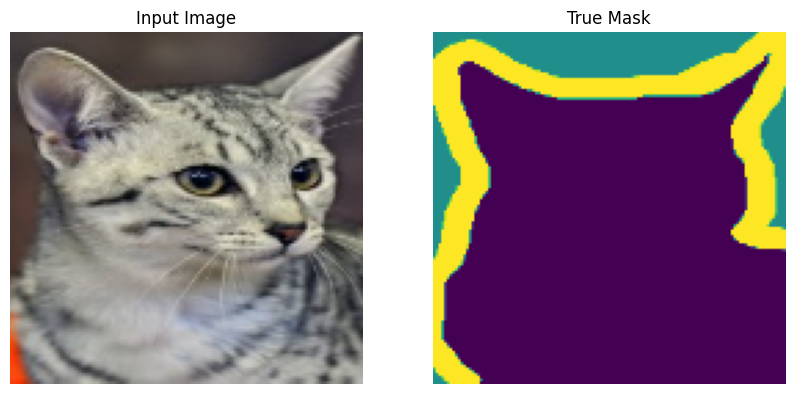

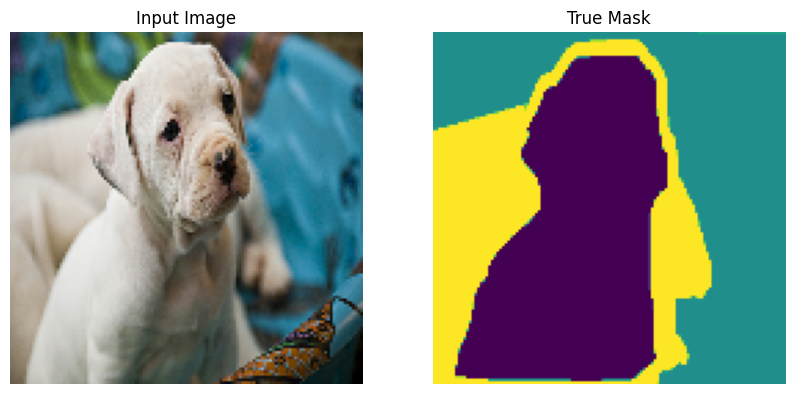

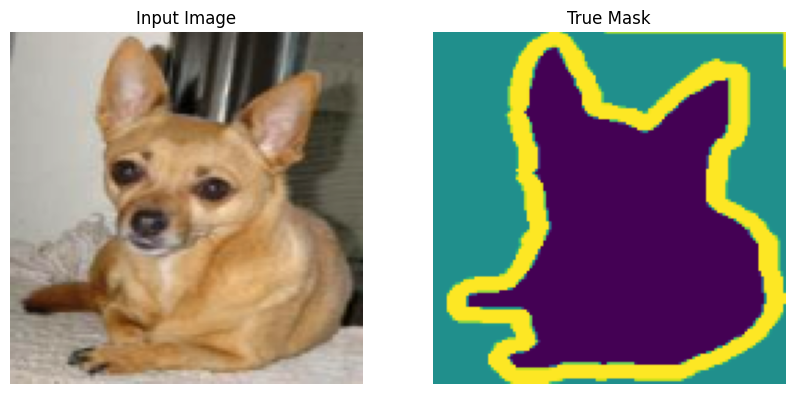

In [9]:
for images, masks in train_dataset.take(3):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

In [10]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [11]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # intermediate block
    intermediate_block = double_conv_block(p4, 1024)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='softmax')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

In [12]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
!apt-get update && apt-get install graphviz -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,804 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,752 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [48.5 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [56.4 kB]
Get:13 http://security.ubun

In [14]:
EPOCHS = 8
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=test_dataset)


Epoch 1/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5669 - loss: 0.9976 - val_accuracy: 0.7053 - val_loss: 0.7236
Epoch 2/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6891 - loss: 0.7394 - val_accuracy: 0.7274 - val_loss: 0.6416
Epoch 3/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7311 - loss: 0.6317 - val_accuracy: 0.7570 - val_loss: 0.5895
Epoch 4/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7579 - loss: 0.5833 - val_accuracy: 0.7789 - val_loss: 0.5330
Epoch 5/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7840 - loss: 0.5240 - val_accuracy: 0.7940 - val_loss: 0.5104
Epoch 6/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7938 - loss: 0.5009 - val_accuracy: 0.8209 - val_loss: 0.4358
Epoch 7/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8184 - loss: 0.4442 - val_accuracy: 0.8249 - val_loss: 0.4271
Epoch 8/8
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8214 - loss: 0.4379 - val_accuracy: 0.8334 - val_loss: 0.410

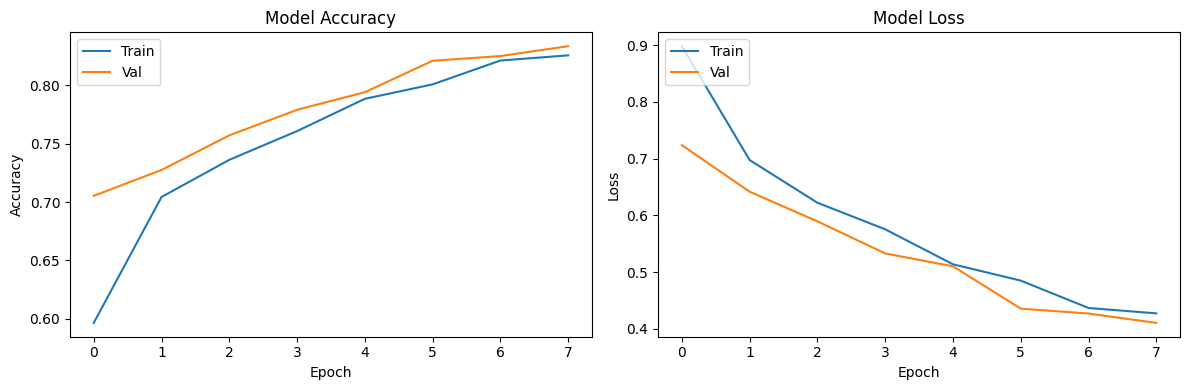

In [15]:
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step


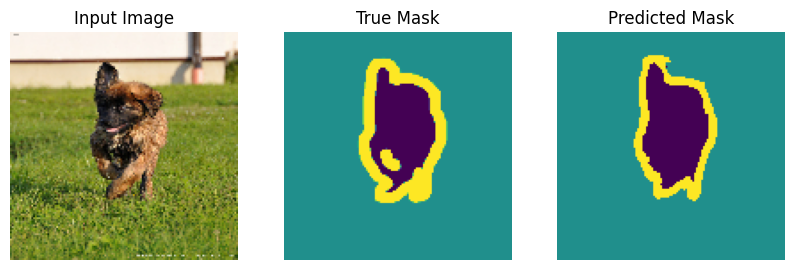

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


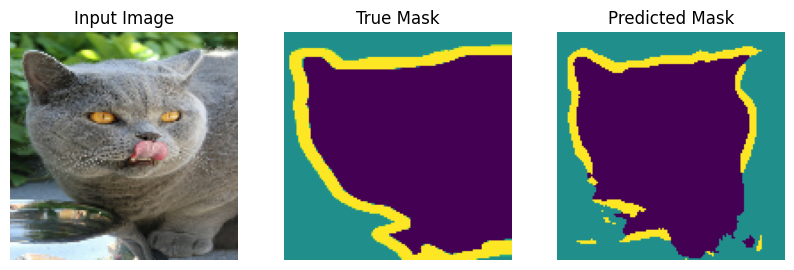

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


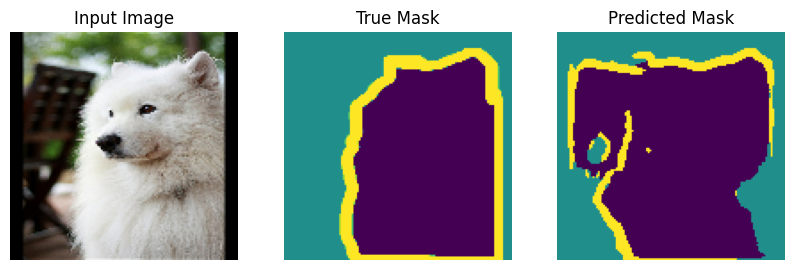

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


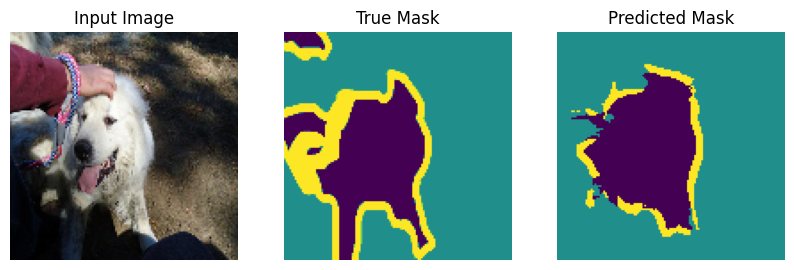

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


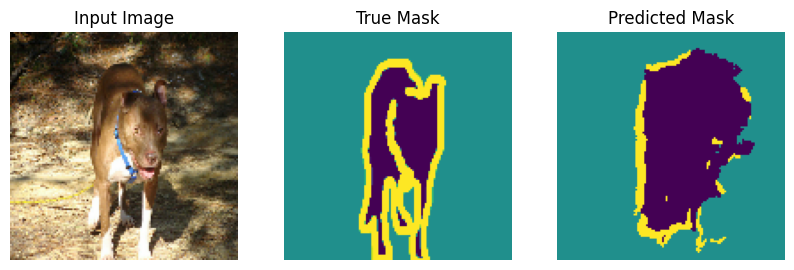

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


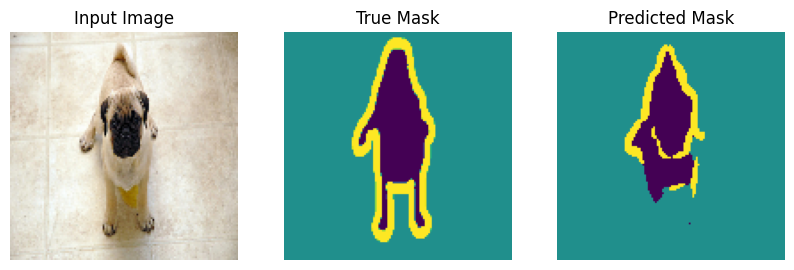

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


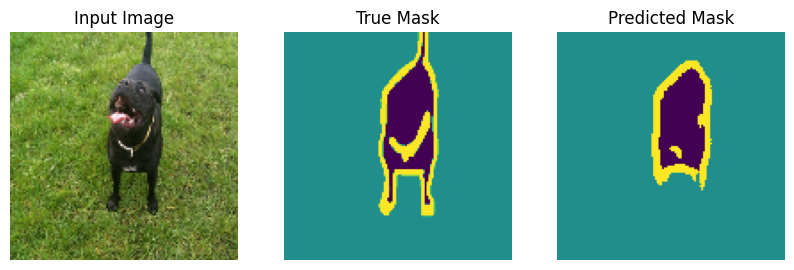

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


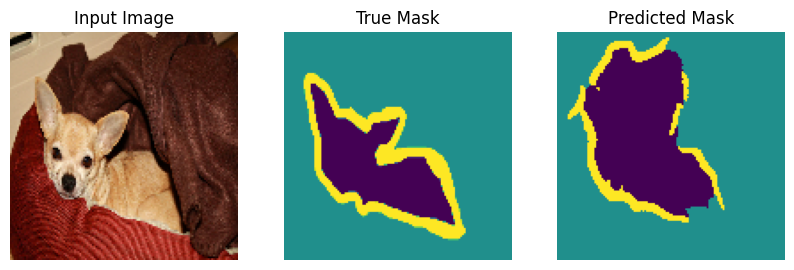

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


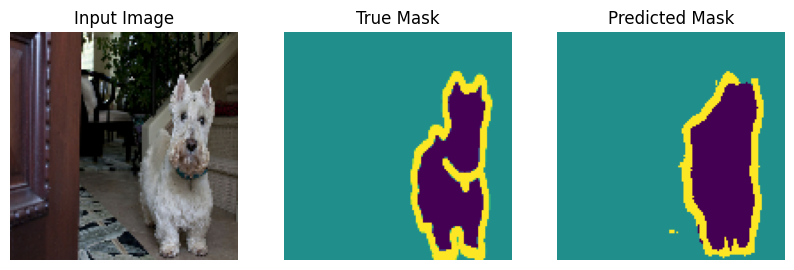

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


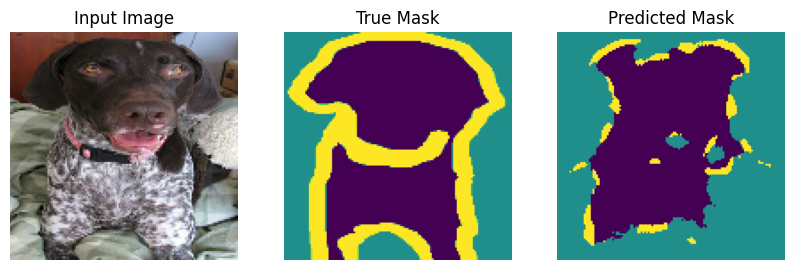

In [17]:
show_predictions(test_dataset, 10)